In [1]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *
from gridtools.hypnotoad_tools import *
from gridtools.b2_tools import *
from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2


print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


# Hermes IO

In [2]:
casestore = dict()

In [142]:
db = CaseDB()

toload = [
    dict(name="fit", id="d7a-tunefrec3_fixgamma", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    dict(name="tn30", id="d8a-tn_30ev", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    dict(name="tn0.03_nonsepfit", id="d8b-tn_0.03ev", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    dict(name="tn0.03", id="d8c-tn_0.03ev_fitnsep", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
]

for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                           double_load = False, keep_xboundaries = True, keep_yboundaries = True,
                                           unnormalise_geom = case["unnormalise_geom"])

CHECK: Total domain volume is 1.942E+00 [m3]
CHECK: Total domain volume is 1.942E+00 [m3]
CHECK: Total domain volume is 1.942E+00 [m3]
CHECK: Total domain volume is 1.942E+00 [m3]


In [10]:
plt.close("all")
%matplotlib inline

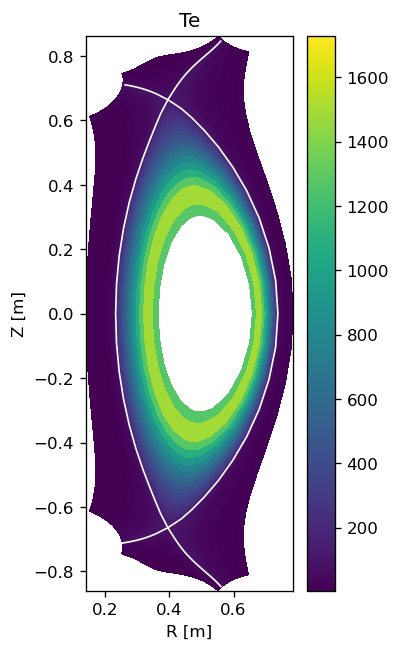

In [62]:
casestore["tn30"].ds["Te"].bout.polygon()

In [9]:
write_file(casestore, r"C:\Users\mikek\OneDrive\Project\collab\tech\notebooks\b1-lineplot-comparison.pkl")

C:\Users\mikek\OneDrive\Project\collab\tech\notebooks\b1-lineplot-comparison.pkl written


## Read Hermes data

In [144]:
hr = dict()
for hermes_case in casestore.keys():
    print(hermes_case)
    hr[hermes_case] = Hermesdata()
    hr[hermes_case].read_case(casestore[hermes_case].ds.isel(t=-1, x = slice(2,-2)))

fit
tn30
tn0.03_nonsepfit
tn0.03


# Read SOLEDGE CSV data

In [143]:
soledgecases = {
    "nocurr_base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\nocurrents_baseline"), # Original case with hydrogen
    "nocore_d" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\copy_wallStd_bra_nocore_D"), # No ionising core BC, deuterium
    "tightwall" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\copy_wallMike_bra_nocore_D"),
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata()
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



In [24]:
path = soledgecases["nocore_d"]
sl["nocore_d"].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")

## Read SOLPS

In [138]:
solpscases = {
    "base" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5",
    "noiz_core" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16",
    "gammai_2.5" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00",
    "dpuff_1e22" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22",
    "dpuff_5e21" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21",
    "no_fast_reflec" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0",
    "nsep_3e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.nesepm=3E+19"
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    sp[name].read_last10s(solpscases[name])

C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5\last10s.pkl loaded
C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16\last10s.pkl loaded
C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00\last10s.pkl loaded
C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22\last10s.pkl loaded
C:\Users\mikek\OneDrive\Project\collab\tech\co

In [148]:
%matplotlib inline

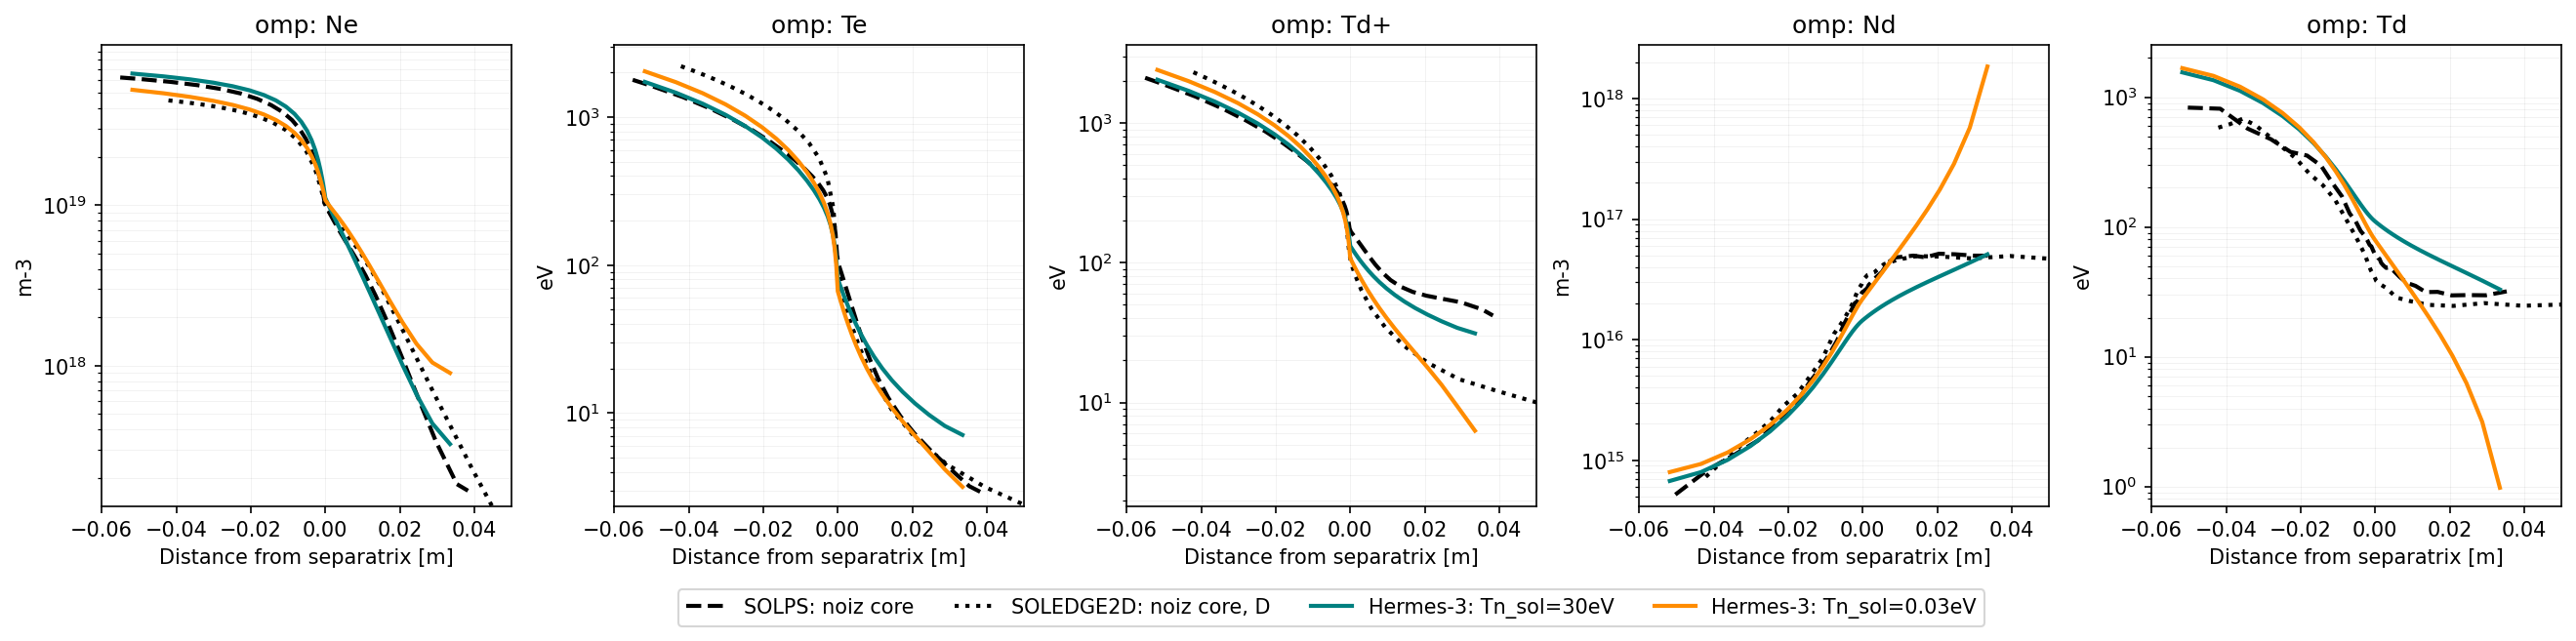

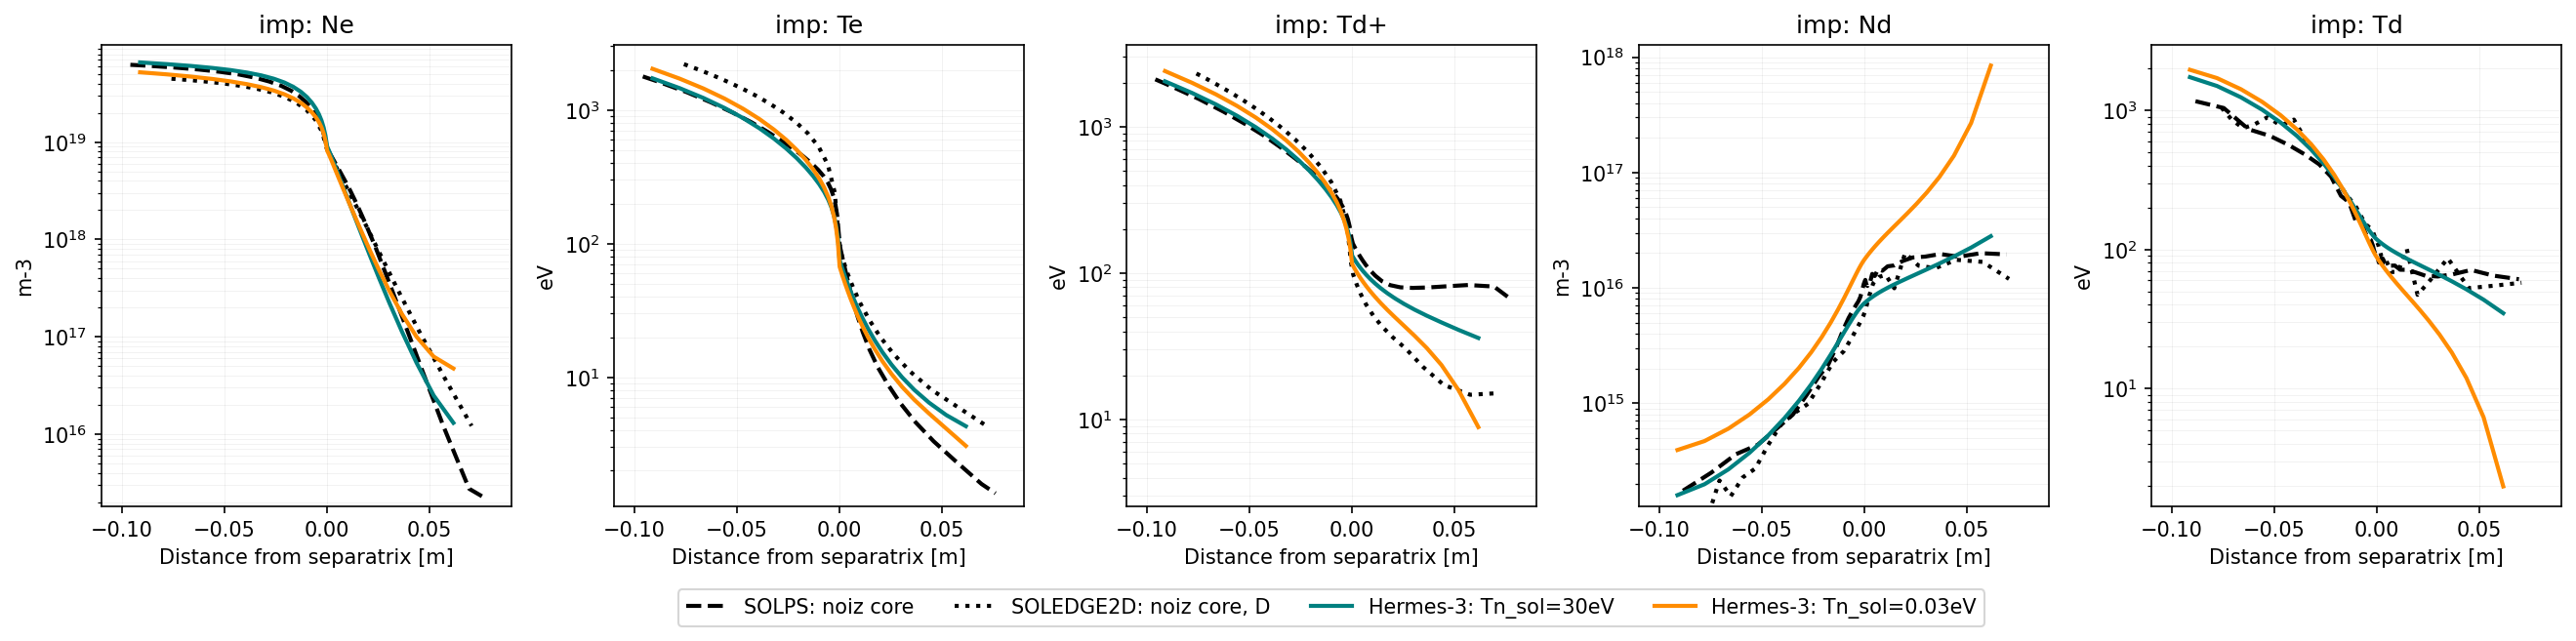

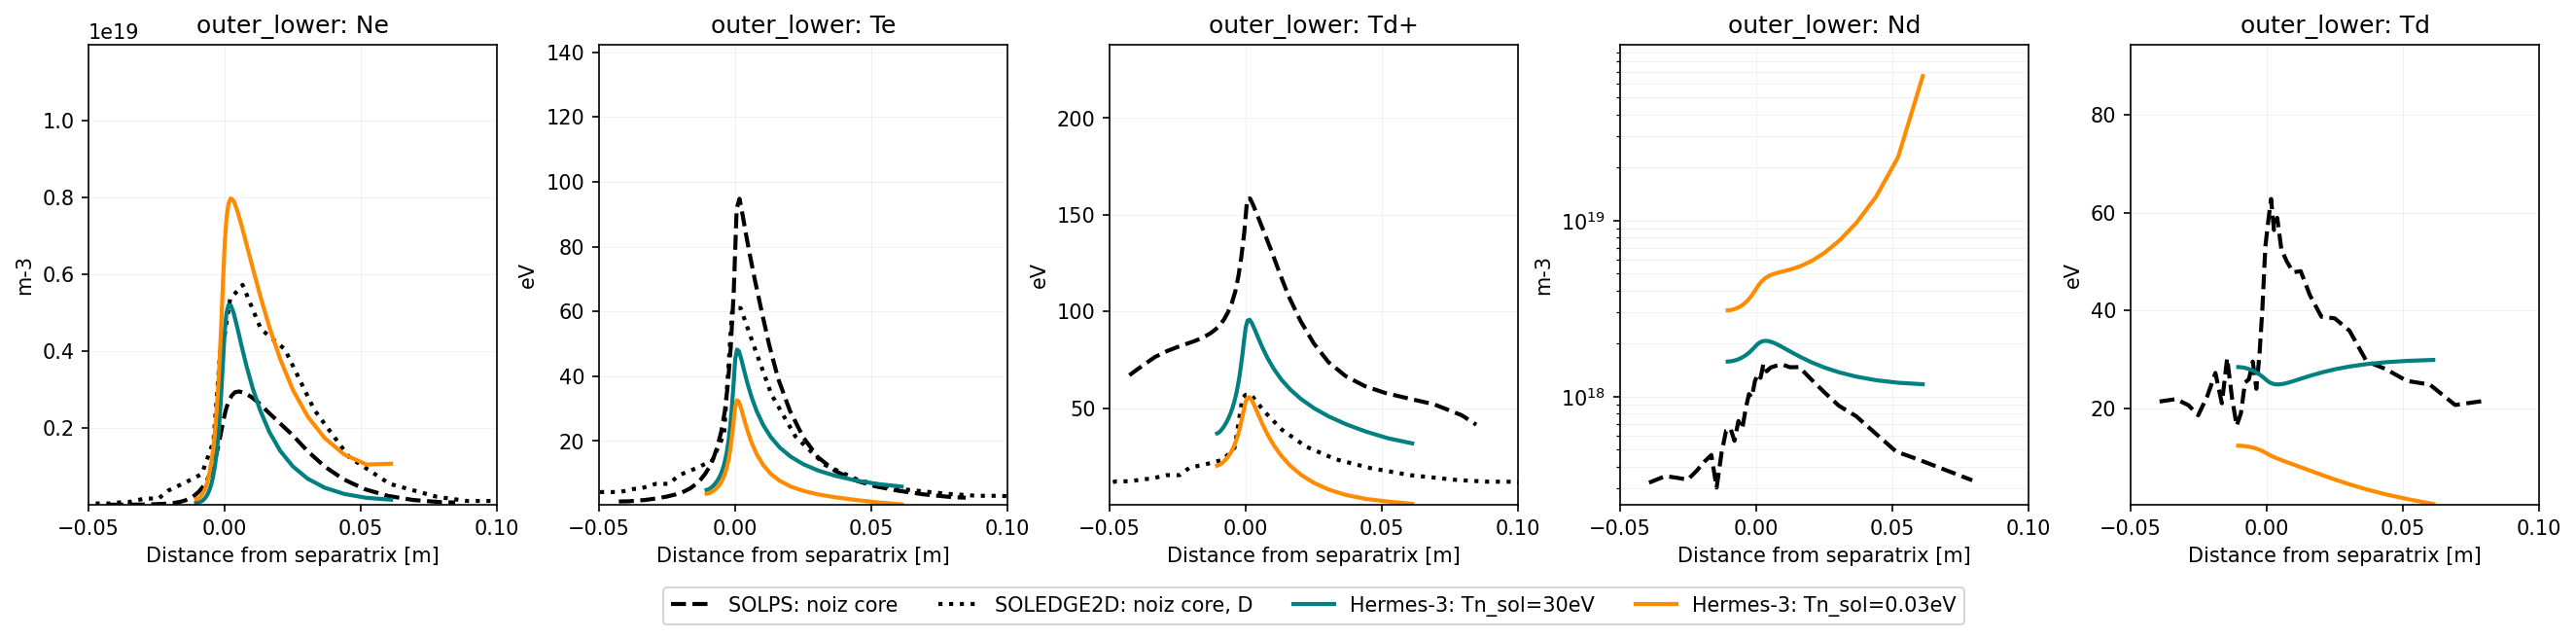

: 

In [151]:

plt.close("all")
lineplot_compare(
    cases = { 
    # "SOLPS: Base" : dict(data=sp["base"], color="teal"),
    # "SOLPS: noiz core" : dict(data=sp["noiz_core"], color="black"),
    # "SOLPS: gammai+1" : dict(data=sp["gammai_2.5"], color="red"),
    # "Hermes-3: Tn_sol=30eV" : dict(data=hr["tn30"], color="grey"),
    # "SOLEDGE2D: Base": dict(data=sl["nocurr_base"], color="teal"),
    # "SOLEDGE2D: noiz core, D": dict(data=sl["nocore_d"], color="darkorange"),
    # "SOLEDGE2D: tight wall" : dict(data=sl["tightwall"], color="blue")
    # "Hermes-3: Fit Nsep, fix D, gamma" : hermes["Base"],
    
    # "SOLPS: noiz core (dpuff=1e21)" : dict(data=sp["noiz_core"], color="teal"),
    # "SOLPS: dpuff=5e21" : dict(data=sp["dpuff_5e21"], color="darkorange"),
    # "SOLPS: dpuff=1e22" : dict(data=sp["dpuff_1e22"], color="firebrick"),
    
    # "SOLPS: noiz core" : dict(data=sp["noiz_core"], color="teal"),
    # "SOLPS: dpuff=5e21" : dict(data=sp["dpuff_5e21"], color="red"),
    # "SOLPS: Lo pump" : dict(data=sp["nsep_3e19"], color="darkorange"),
    
    "SOLPS: noiz core" : dict(data=sp["noiz_core"], color="black"),
    "SOLEDGE2D: noiz core, D": dict(data=sl["nocore_d"], color="black"),
    "Hermes-3: Tn_sol=30eV" : dict(data=hr["tn30"], color="teal"),
    # "Hermes-3: Tn_sol=0.03eV" : dict(data=hr["tn0.03_nonsepfit"], color="darkorange"),
    "Hermes-3: Tn_sol=0.03eV" : dict(data=hr["tn0.03"], color="darkorange"),
    
    },
    # regions = ["omp", "imp"], params = ["Ne", "Td+", "Te"],
    # regions = ["omp", "imp"], params = ["Nd", "Td", "Sd+_iz"],
    regions = ["omp", "imp", "outer_lower"], params = ["Ne", "Te", "Td+", "Nd", "Td"],
    # regions = ["omp", "imp", "outer_lower"], params = ["Nd", "Td"],
    # regions = ["omp"], params = []
    mode = "log",
    dpi = 150,
    lw = 2
)

In [15]:
plt.close("all")

In [30]:
%matplotlib widget

In [28]:
casestore.keys()

dict_keys(['fit', 'n_cooling'])

# Comparing new grids

In [21]:
p1 = SOLEDGEplot(path = soledgecases["nocurr_base"], param = name_parser("Te", "soledge"))
p2 = SOLEDGEplot(path = soledgecases["nocore_d"], param = name_parser("Te", "soledge"))
p3 = SOLEDGEplot(path = soledgecases["tightwall"], param = name_parser("Te", "soledge"))

	load_plasma_files: Loading:  c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\soledge_cases\nocurrents_baseline/Results/plasma_0
	load_plasma_files: Loading:  c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\soledge_cases\nocurrents_baseline/Results/plasma_1
load_soledge_mesh_file: reading file  c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\soledge_cases\nocurrents_baseline\mesh.h5
	load_soledge_mesh_file: in_equ = OK
	h5_read: error reading:  /mesher/Fields/RadArroundXp
	load_soledge_mesh_file: extrapol = OK
	load_soledge_mesh_file: xPoints = OK
	load_soledge_mesh_file: Frontiers = OK
	load_soledge_mesh_file: Limits = OK
	h5_read: error reading:  /mesher/OMP_segment/mesher/refpoints/nPoints
	load_soledge_mesh_file: Segments = OK
	load_soledge_mesh_file: MagGrid_OK = OK
	load_soledge_mesh_file: new_equ = OK
	load_soledge_mesh_file: equ = OK
	load_soledge_mesh_file: Mesh = OK
	load_soledge_mesh_file: transp_prof = OK
	load_soledge_mesh_file: transp_values = O

## New extended grid

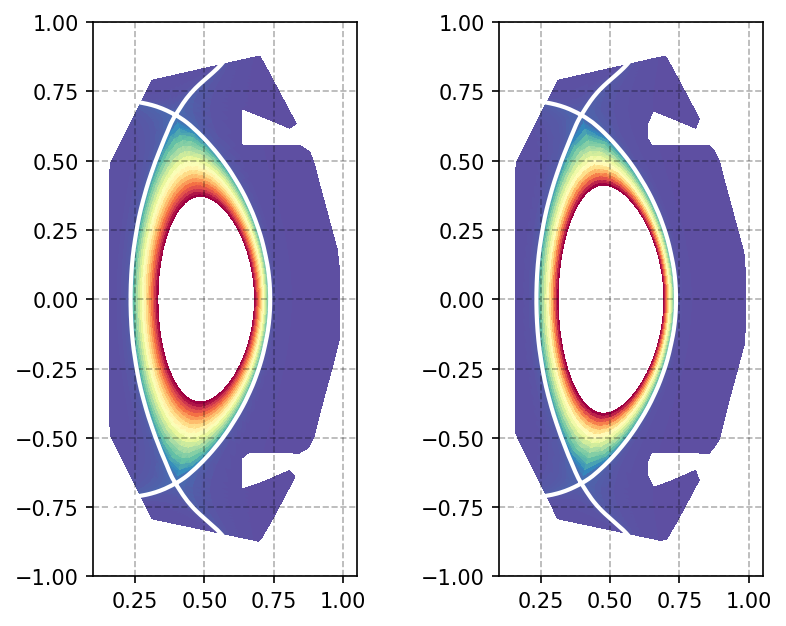

In [69]:
fig, axes = plt.subplots(1, 2, dpi = 150)

p1.plot(ax = axes[0], )
p2.plot(ax = axes[1])

for ax in axes:
    ax.set_ylim((-1,1))
    ax.set_xlim(0.1,1.05)
    ax.grid(color = "k", alpha = 0.3, ls = "--")

## New tight grid

In [49]:
p3.vmax

2770.1791007294473

In [84]:
sp = SOLPSplot(solpscases["noiz_core"], param = "te")

b2fgmtry loaded from .pkl


In [87]:
g = read_b2fgmtry(where=solpscases["base"])

b2fgmtry loaded from .pkl


In [90]:
g["crx"].shape

(110, 36, 4)

In [108]:
wall = pd.read_csv(r"C:\Users\mikek\OneDrive\Project\collab\tech\grid\ST40\matteo-mod\ST40_IVC2_wall_HERMES_SOLEDGE.ogr", names = [0,1], sep = " ")

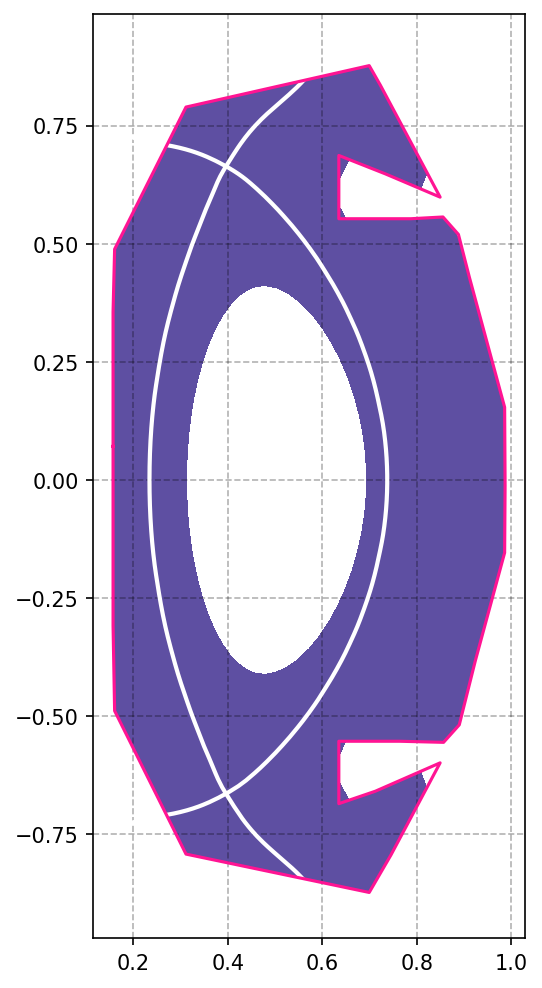

In [113]:
fig, ax = plt.subplots( dpi = 150, figsize = (8,8))

p2.plot(ax = ax, vmin = 10000, vmax = 1e6)


# hr["tn30"].ds["Td+"].bout.polygon(ax = ax, alpha = 0.2, linewidth = 0.1, separatrix = False, vmax = 0.01)

ax.plot(wall[0]/1000, wall[1]/1000, color = "deeppink")


# ax.set_ylim((-1,0.1))
# ax.set_xlim(0.1,1.05)
ax.grid(color = "k", alpha = 0.3, ls = "--")

	load_plasma_files: Loading:  c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\soledge_cases\copy_wallStd_bra_nocore_D/Results/plasma_0
	load_plasma_files: Loading:  c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\soledge_cases\copy_wallStd_bra_nocore_D/Results/plasma_1
load_soledge_mesh_file: reading file  c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\soledge_cases\copy_wallStd_bra_nocore_D\mesh.h5
	load_soledge_mesh_file: in_equ = OK
	h5_read: error reading:  /mesher/Fields/RadArroundXp
	load_soledge_mesh_file: extrapol = OK
	load_soledge_mesh_file: xPoints = OK
	load_soledge_mesh_file: Frontiers = OK
	load_soledge_mesh_file: Limits = OK
	h5_read: error reading:  /mesher/OMP_segment/mesher/refpoints/nPoints
	load_soledge_mesh_file: Segments = OK
	load_soledge_mesh_file: MagGrid_OK = OK
	load_soledge_mesh_file: new_equ = OK
	load_soledge_mesh_file: equ = OK
	load_soledge_mesh_file: Mesh = OK
	load_soledge_mesh_file: transp_prof = OK
	load_soledge_mesh_file:

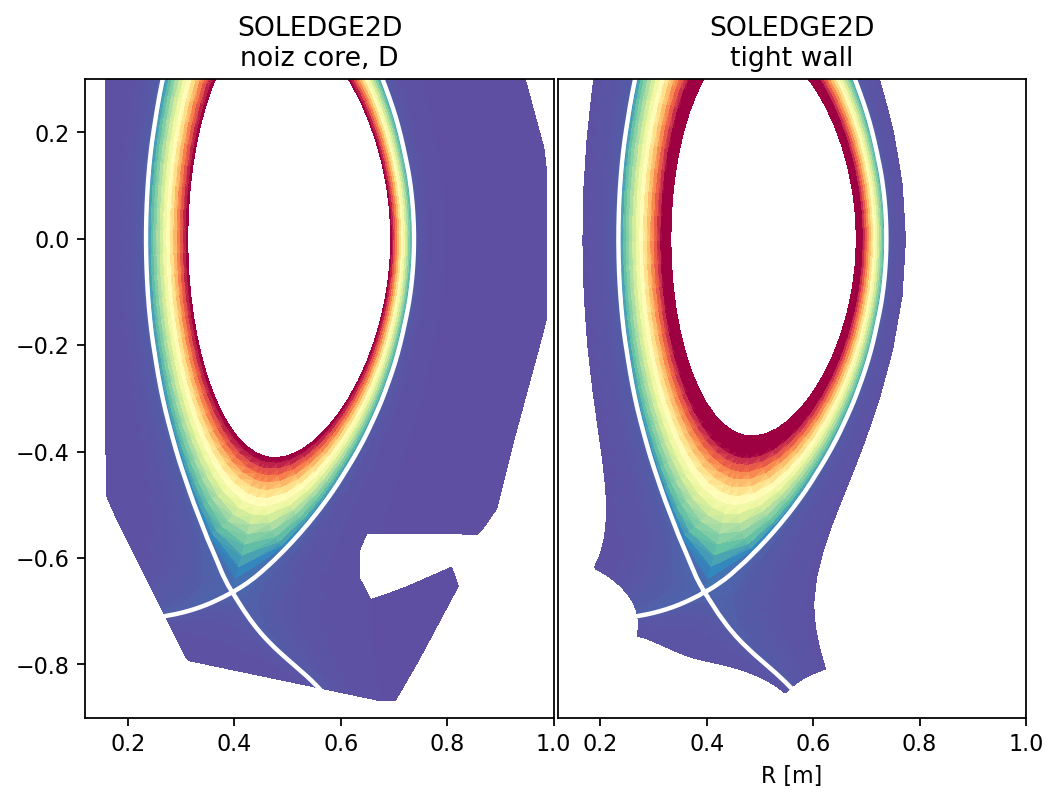

In [77]:
v = viewer_2d(
    "Te",
    {
        # "Case 1"  : {"code":"hermes", "ds" : casestore["fit"].ds.isel(t=-1)},
        # "Cooled N"  : {"code":"hermes", "ds" : casestore["n_cooling"].ds.isel(t=-1)},
        # "Baseline" : {"code":"soledge", "path" : soledgecases["nocurr_base"]},
        "noiz core, D" : {"code":"soledge", "path" : soledgecases["nocore_d"]},
        "tight wall" : {"code":"soledge", "path" : soledgecases["tightwall"]},
        # "noiz core, D" : {"code":"solps", "path" : solpscases["noiz_core"]}
        # "Tn = 30eV" : {"code":"hermes", "ds" : caseng.ds.isel(t=-1)}
    },
    logscale = False,
    # vmin = 10,
    # vmax = 2000,
    # vmin = 1e17,
    # vmax = 5e17,
    dpi = 160,
    ylim = (-0.9,0.3),
    xlim = (0.12, 1.0),
    wspace = 0.0,
    cmap = "Spectral_r"
)

In [80]:
from code_comparison.viewer_2d import *
plt.close("all")
v = viewer_2d(
    param = "Ne",
    cases =     {
        "base" : {"code" : "solps",  "path" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF"},
        # "Pf=0" : {"code" : "solps", "path" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"},
        "fit_nsep" : {"code" : "hermes", "ds" : casestore["fit_nsep"].ds.isel(t=-1)},
        # "core src" : {"code" : "hermes", "ds" : casestore["sources"].ds.isel(t=-1)},
        # "solps_base" : {"code" : "solps", "path" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF"},
        # "no core rec, BCCON=8" : {"code" : "solps", "path" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=8"}
        },
    # vmin = 1,
    # vmax = 150,
    xlim = (0.12, 1.0),
    # ylim = (-1, 1),
    ylim = (-1,0.2),
    
    logscale = False,
    dpi = 150,
    # antialias = True,
    # linewidth = 0.1,
    # color = "k"
    )

KeyError: 'fit_nsep'

In [38]:
cases =     {
        "base" : {"code" : "solps", "param_override" : "dab2", "path" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF"},
        "Pf=0" : {"code" : "solps", "path" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"},
        # "fit_nsep" : {"code" : "hermes", "ds" : casestore["fit_nsep"].ds.isel(t=-1)},
        # "core src" : {"code" : "hermes", "ds" : casestore["sources"].ds.isel(t=-1)},
        # "solps_base" : {"code" : "solps", "path" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF"},
        # "no core rec, BCCON=8" : {"code" : "solps", "path" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=8"}
        },

In [39]:
any(["hermes" in x["code"] for x in cases])

KeyError: 'code'

In [53]:
solps = SOLPSdata()
path = r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"
solps.read_last10s(path)
# solps.read_dataframes(r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\last10s_dfs")

C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF\last10s.pkl loaded


In [49]:
last10s = read_file(os.path.join(path, "last10s.pkl"))
dfs = dict()
        
for param in last10s.keys():
    # if any([x in param for x in ["ti3", "te3", "ne3", "dab23", "dmb23"]]):
    if len(np.array(last10s[param]).shape) == 2: 
        if last10s[param].shape[1] == 2:
            if any([param.endswith(x) for x in ["da", "dr", "di"]]):
                dfs[param] = pd.DataFrame(last10s[param])
                dfs[param].columns = ["pos", param]
                dfs[param] = dfs[param].set_index("pos")
                dfs[param].index = dfs[param].index.astype(float)
    
    
                if param.endswith("da"): #re.search(".*da", param):
                    self.params["omp"][param] = df
                    
                elif param.endswith("dr"):
                    self.params["outer_lower"][param] = df
                    
                elif param.endswith("di"):
                    self.params["imp"][param] = df

C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF\last10s.pkl loaded


# Recreate last10s

In [135]:
from gridtools.solps_python_scripts.utilities.last10s import read_last10s
import shutil
# from gridtools.solps_python_scripts.reactions.compute_rates import compute_rates

directory = r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE"

for folder in os.listdir(directory):
    if "HERMES_SOLEDGE" in folder:
        print(folder)
        casepath = os.path.join(directory,folder)
        if "last10s.pkl" in os.listdir(casepath):
            os.remove(os.path.join(casepath, "last10s.pkl"))
        last10s = read_last10s(where = casepath, save = True)

# path = r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_hydrogen\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"
# x = read_last10s(where = path, save = True)


HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5
read_last10s
fort.44 loaded from .pkl
b2fgmtry loaded from .pkl
compute_rates - rates.pkl
HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16
read_last10s
fort.44 loaded from .pkl
b2fgmtry loaded from .pkl
compute_rates - rates.pkl
HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22
read_last10s
fort.44 loaded from .pkl
b2fgmtry loaded from .pkl
compute_rates - rates.pkl
HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21
read_last10s
fort.44 loaded from .pkl
b2fgmtry loaded from .pkl
compute_rates - rates.pkl
HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=

In [46]:
path

'C:\\Users\\mikek\\OneDrive\\Project\\collab\\tech\\compare_data\\playAround_ST40_IVC2_HERMES_SOLEDGE_hydrogen\\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5'

In [47]:
casepath

'C:\\Users\\mikek\\OneDrive\\Project\\collab\\tech\\compare_data\\playAround_ST40_IVC2_HERMES_SOLEDGE\\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.input.dat.OK'

In [30]:
x = read_file(os.path.join(path, "last10s.pkl"))

C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF\last10s.pkl loaded


(-0.8546891342273759, 0.0)

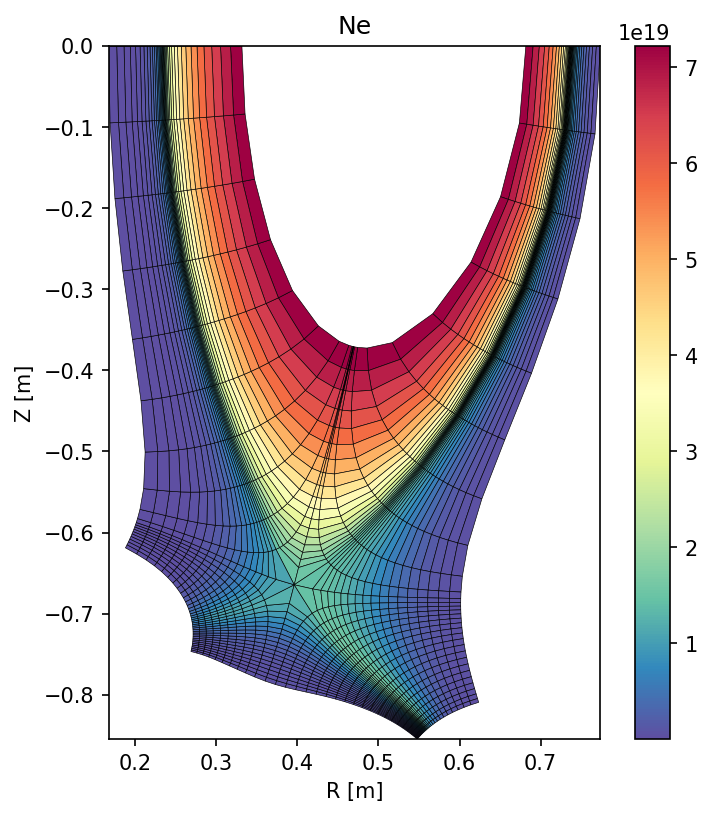

In [81]:
fig, ax = plt.subplots(figsize=(6,6), dpi = 150)
casestore["puff"].ds["Ne"].isel(t=-1, x = slice(2,-2)).bout.polygon(cmap = "Spectral_r", antialias=True, linewidth=0.3, ax = ax)
ax.set_ylim(None,0)